# External signals

Apziva project #5<br>
2023 09 04

__Summary:__
* __External regressors__ are variables that are believed to have an influence on the target time series. 
    * These variables can be factors, events, or any other data that might impact the time series.
    * In the Prophet applied by using the `add_regressor` method
    * Other terms: 
        * external factor
        * external signal
        * additional external regressor
        * covariate
* Currently, the external signals seems not to be incorporated into the model:
    * In the final plot of this notebook the `extra_regressors_additive` appears as a straight horizontal line at y = 0.

__Suggestions SSM__
* https://paperswithcode.com/task/stock-a1fltPrices-prediction
* https://github.com/topics/stock-a1fltPrices-prediction

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## Prophet model <a class="anchor" id="ProphetModel"></a>
[TOC](#TOC)

16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing


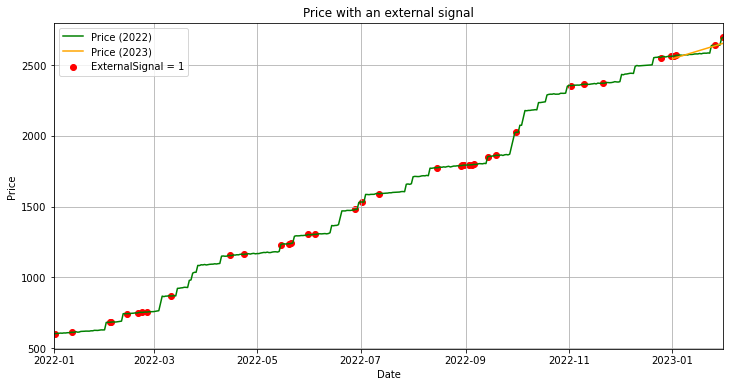

Model parameters
- model parameters: 7, e.g.:
  - k: 0.284434
  - m: 0.217869
- change points: 25, e.g. 2022-01-14
- seasonality mode: additive

Model components


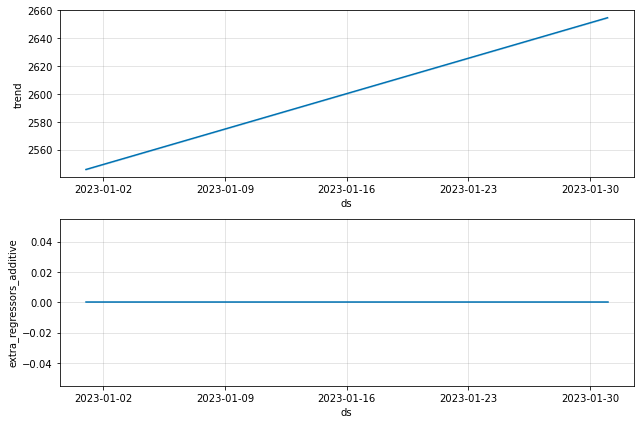

In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
import random
import matplotlib.pyplot as plt

# init
fltRandSeed = 42
intDelay = 30
fltIncrease = 50
fltPropComProbabilityZero = 0.90
fltNoiseStandardDeviation = 1.5
intInitialPrice = 600
np.random.seed(fltRandSeed)

cfltImpactProbablyStrong = 0.01
cfltImpactProbablyMedium = 3.0
cfltImpactProbablyWeek = 10.0

# generate data for 2022 (training) and 2023 (test)
ldatAllDays = list(pd.date_range(start="2022-01-01", end="2023-01-31"))
a1fltPrices = np.linspace(intInitialPrice, intInitialPrice+len(ldatAllDays)-1, len(ldatAllDays)) # 1$ per day, if no noise
a1fltExternalSignal = np.random.choice([0, 1], size=len(ldatAllDays), p=[fltPropComProbabilityZero, 1-fltPropComProbabilityZero])
a1fltNoise = np.random.normal(0, fltNoiseStandardDeviation, len(ldatAllDays))
a1fltPrices += a1fltNoise

# apply impact of ExternalSignal
for intOuterDay in range(len(ldatAllDays)):
    if a1fltExternalSignal[intOuterDay] == 1:        
        for intInnerDay in range(intOuterDay + intDelay, len(ldatAllDays)):
            a1fltPrices[intInnerDay] += fltIncrease

# combine prices and PropCom
dfrTimeSeries = pd.DataFrame({"ds": ldatAllDays, "y": a1fltPrices, "ExternalSignal": a1fltExternalSignal})

# build model
objProphetModel = Prophet()
objProphetModel.weekly_seasonality = False
objProphetModel.yearly_seasonality = False
objProphetModel.add_regressor("ExternalSignal",prior_scale=cfltImpactProbablyStrong)
objProphetModel.fit(dfrTimeSeries)

# predict future
ldatFutureDays = list(pd.date_range(start="2023-01-01", end="2023-01-31"))
dfrFuture = pd.DataFrame({"ds": ldatFutureDays, "ExternalSignal": 0})
dfrForecast = objProphetModel.predict(dfrFuture)

# plot
plt.figure(figsize=(12, 6))
plt.plot(dfrTimeSeries['ds'], dfrTimeSeries['y'], label='Price (2022)', color='green')
plt.plot(dfrForecast['ds'], dfrForecast['yhat'], label='Price (2023)', color='orange')
plt.scatter(dfrTimeSeries['ds'][dfrTimeSeries['ExternalSignal'] == 1], dfrTimeSeries['y'][dfrTimeSeries['ExternalSignal'] == 1], c='red', marker='o', label='ExternalSignal = 1')
plt.title('Price with an external signal')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-01-31'))
plt.legend()
plt.grid(True)
plt.show()

# model description
p("Model parameters")
p(f"- model parameters: {len(objProphetModel.params)}, e.g.:")
p(f"  - k: {float(objProphetModel.params['k'])}")
p(f"  - m: {float(objProphetModel.params['m'])}")
p(f"- change points: {len(objProphetModel.changepoints)}, e.g. {str(list(objProphetModel.changepoints)[0])[:10]}")
p(f"- seasonality mode: {objProphetModel.seasonality_mode}")
p()

p("Model components")
fig = objProphetModel.plot_components(dfrForecast)